# (test) Grades distribution

Here we will try to fit a probability distribution over the grades of a class.

In [2]:
import pandas as pd

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

df = pd.read_pickle('../data/process/schools2017.pkl')

# let's fit Math first
mean_scores = df['Mean Scale Score - Math']

columns = ['% Level 1 - Math', '% Level 2 - Math', '% Level 3 - Math', '% Level 4 - Math']
df = df[columns] / 100

df.head()

,% Level 1 - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math
DBN,,,,
01M034,0.519231,0.346154,0.134615,0.000000
01M140,0.473684,0.385965,0.140351,0.000000
01M184,0.096386,0.168675,0.289157,0.445783
01M188,0.326923,0.461538,0.211538,0.000000
01M301,0.487805,0.365854,0.121951,0.024390


In [3]:
import matplotlib.pyplot as plt

sample = df.sample(20, random_state=1)
for DBN, row in sample.iterrows():
    xs = [1.0, 2.0, 3.0, 4.0]
    ys = row.values
    widths = [1.0, 1.0, 1.0, 0.5]
    plt.figure(figsize=(6, 4))
    plt.bar(xs, ys, widths, align='edge', tick_label=xs)
    plt.title(DBN)
    plt.xlabel('Math Grade')
    plt.ylabel('Frequency')

The normal hypothesis seem to fit well... We will use a truncated normal distribution probability.


Fuuuck, I need the average proficiency (it is present in the SHSAT dataset, but, here, it is a raw value)


*We can convert the scores based on this:*

http://www.p12.nysed.gov/irs/pressRelease/20170822/documents/ScaleScoretoPerformanceLevelMath.pdf


Grade 7 (2017)

In [4]:
ranges = [[160, 292], [293, 321], [322, 347], [348, 401]]

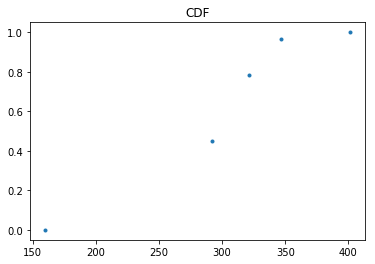

In [5]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm, truncnorm

# CDF

sample = df.sample(1, random_state=1)
for DBN, row in sample.iterrows():
    x_min = ranges[0][0]
    x_max = ranges[-1][-1]
    
    # values
    xs = [r[1] for r in ranges]
    ys = np.cumsum(row).values
    
    # add initial point
    xs = np.insert(xs, 0, x_min)
    ys = np.insert(ys, 0, 0)
    
    # plot
    fig, ax = plt.subplots()
    plt.plot(xs, ys, '.')
    
    plt.title('CDF')

In [6]:
ranges = np.array([[160, 292], 
                   [293, 321], 
                   [322, 347], 
                   [348, 401]])

x_min = ranges.min()
x_max = ranges.max()
scaled_ranges = (ranges - x_min) / (x_max - x_min)  # scale to the interval [0, 1]
scaled_ranges

array([[0.        , 0.54771784],
       [0.55186722, 0.66804979],
       [0.67219917, 0.77593361],
       [0.78008299, 1.        ]])

In [7]:
scaled_means = (mean_scores - x_min) / (x_max - x_min)
scaled_means.head()

DBN
01M034    0.522582
01M140    0.544588
01M184    0.745638
01M188    0.558091
01M301    0.531930
Name: Mean Scale Score - Math, dtype: float64

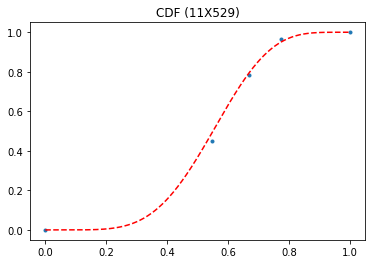

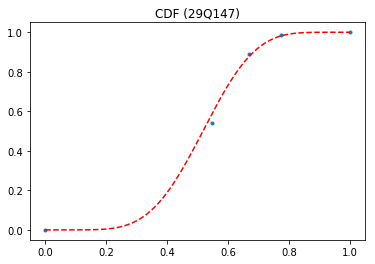

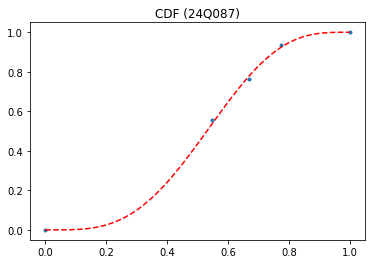

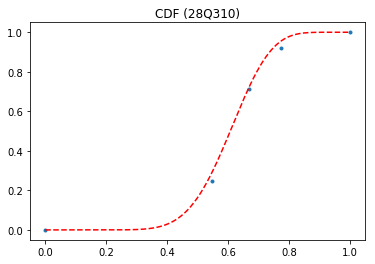

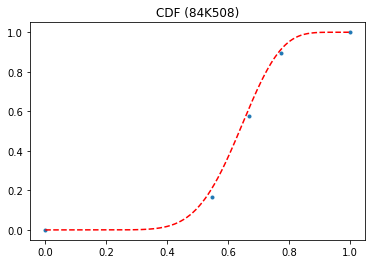

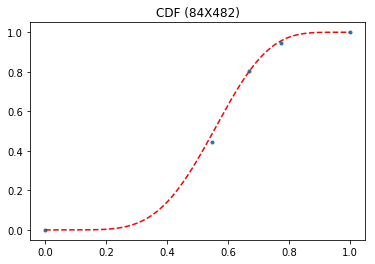

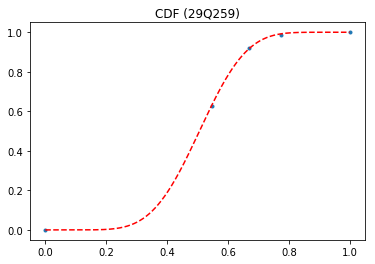

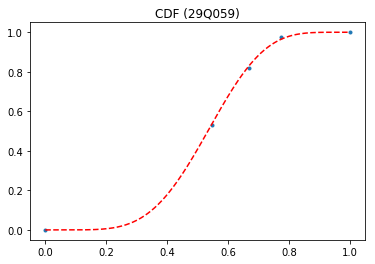

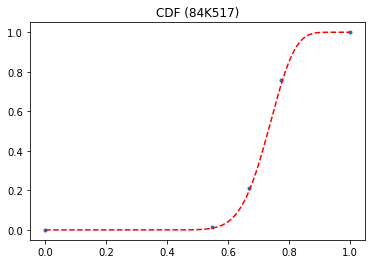

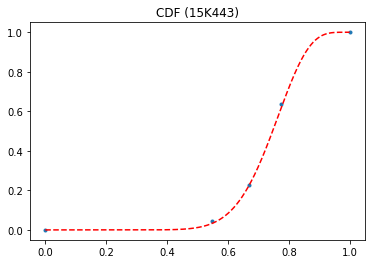

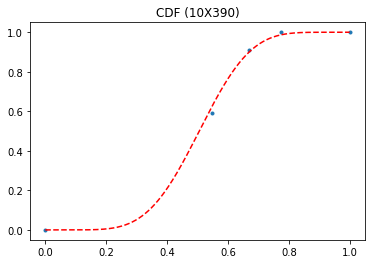

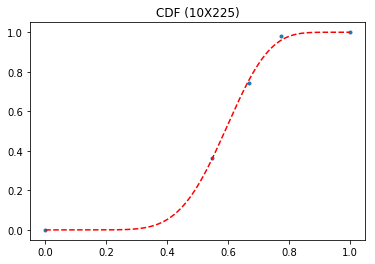

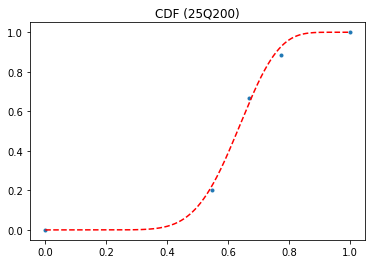

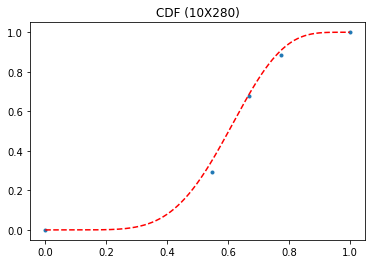

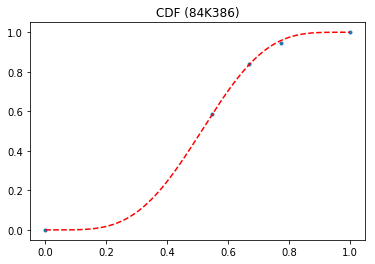

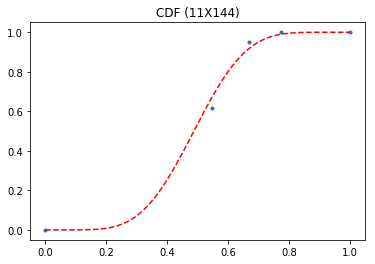

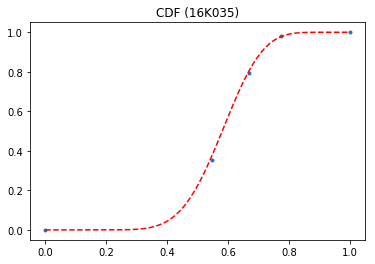

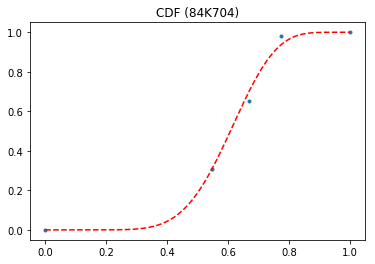

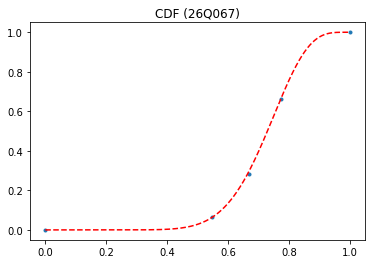

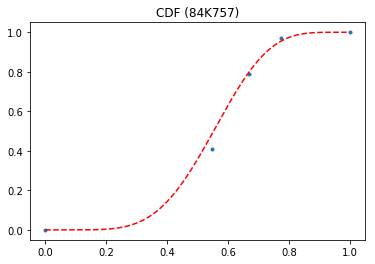

In [58]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import beta

# Beta distribution (bounded) (nice, underfitting a tidy bit)

sample = df.sample(20, random_state=1)
for DBN, row in sample.iterrows():       
    # values
    xs = scaled_ranges[:, 1]
    ys = np.cumsum(row).values
    
    # add initial point
    xs = np.insert(xs, 0, 0)
    ys = np.insert(ys, 0, 0)
    
    # plot
    fig, ax = plt.subplots()
    plt.plot(xs, ys, '.')   
    plt.title('CDF ({})'.format(DBN))
    
    # estimate beta parameters
    mean = scaled_means.loc[DBN]
    def cdf(x, a):
        b = a / mean - a 
        return beta.cdf(x, a, b)
    popt, pcov = curve_fit(cdf, xs, ys)
    
    # plot estimated distribution
    xs = np.linspace(0, 1, 1000)
    ys = cdf(xs, *popt)
    plt.plot(xs, ys, 'r--')

This is just absurd. It fitted enchantingly well :D


Now we need to deal with other stuff

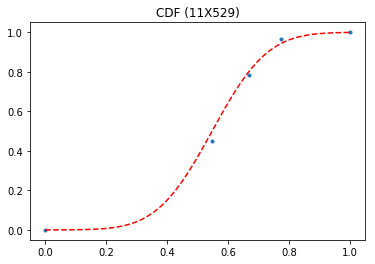

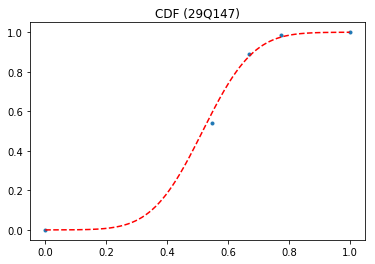

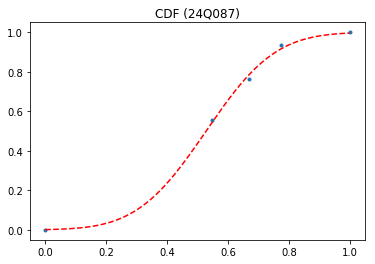

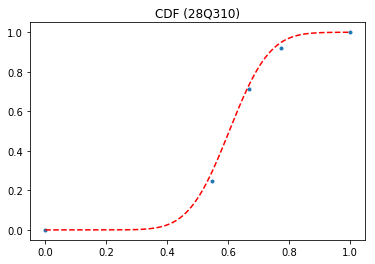

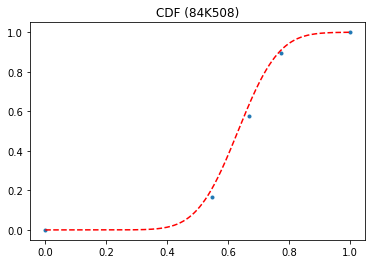

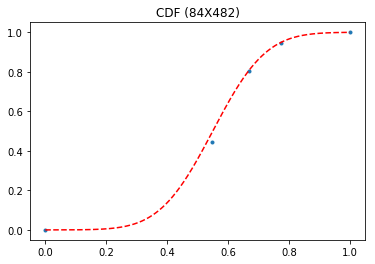

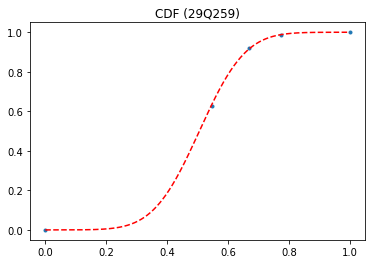

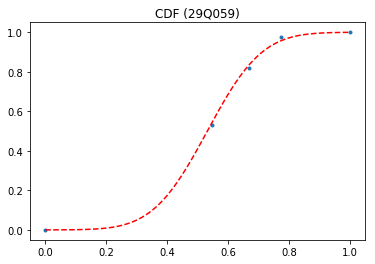

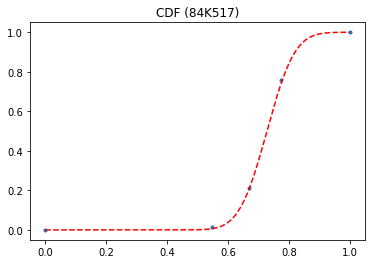

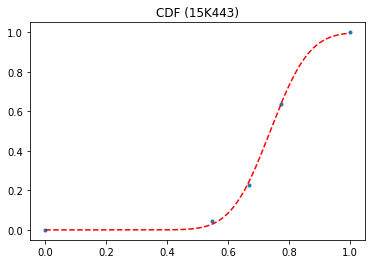

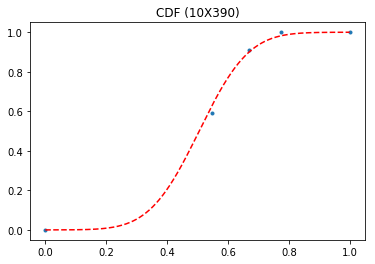

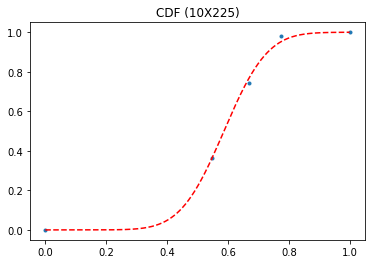

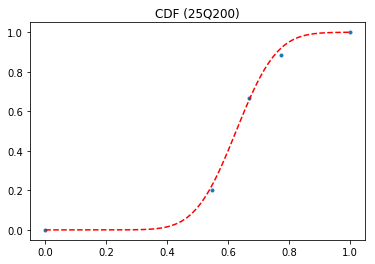

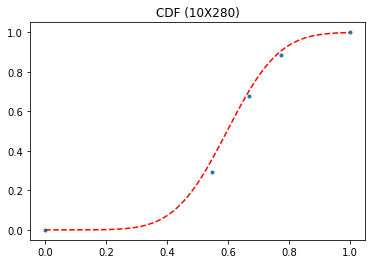

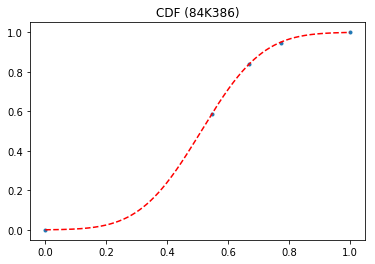

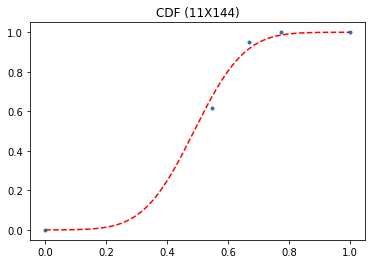

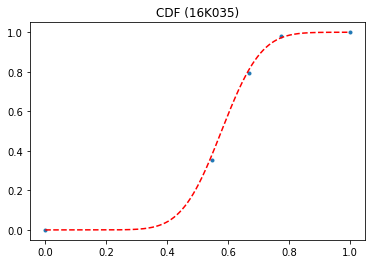

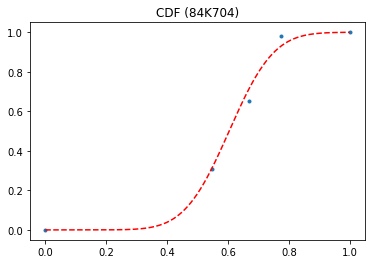

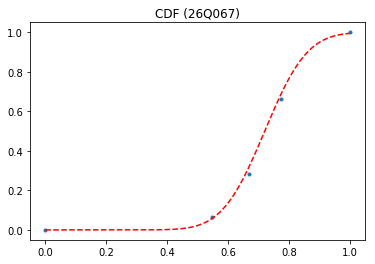

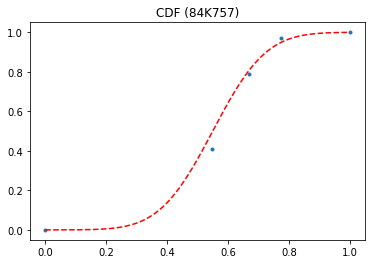

In [48]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

# Normal distribution (nice and simple, nuderfitting a tidy bit)

sample = df.sample(20, random_state=1)
for DBN, row in sample.iterrows():       
    # values
    xs = scaled_ranges[:, 1]
    ys = np.cumsum(row).values
    
    # add initial point
    xs = np.insert(xs, 0, 0)
    ys = np.insert(ys, 0, 0)
    
    # plot
    fig, ax = plt.subplots()
    plt.plot(xs, ys, '.')   
    plt.title('CDF ({})'.format(DBN))
    
    # estimate norm parameters
    mean = scaled_means.loc[DBN]
    def cdf(x, scale):
        return norm.cdf(x, mean, scale)    
    popt, pcov = curve_fit(cdf, xs, ys)
    
    # plot estimated distribution
    xs = np.linspace(0, 1, 1000)
    ys = cdf(xs, *popt)
    plt.plot(xs, ys, 'r--')

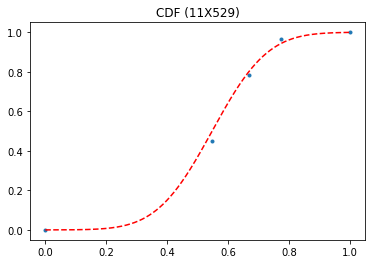

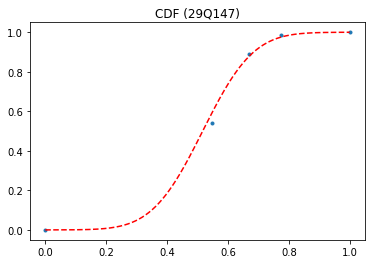

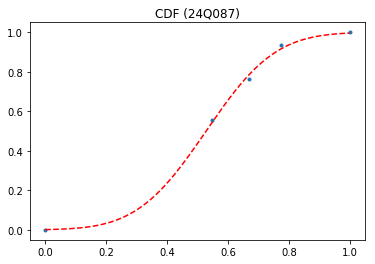

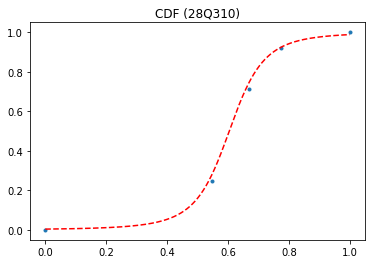

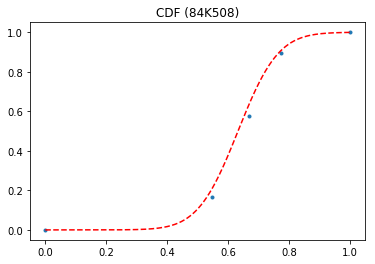

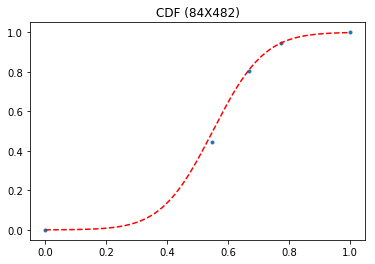

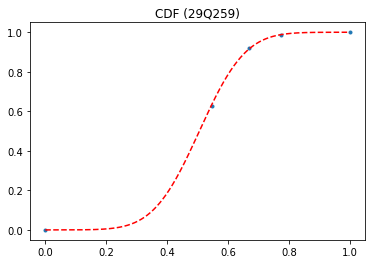

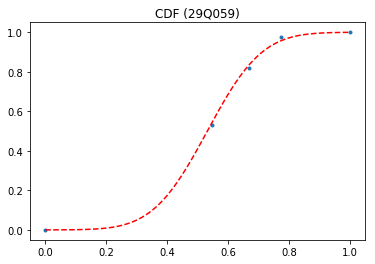

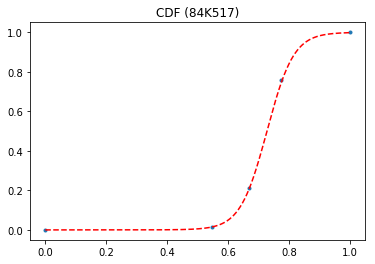

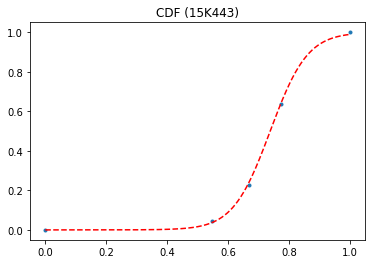

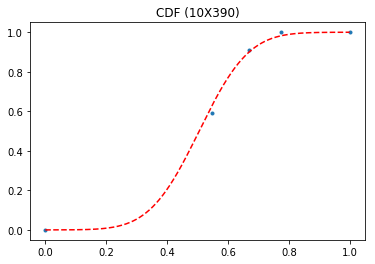

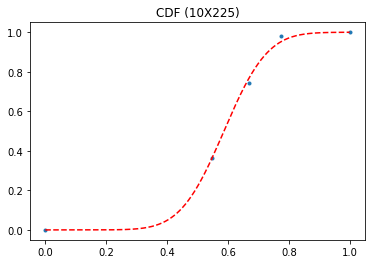

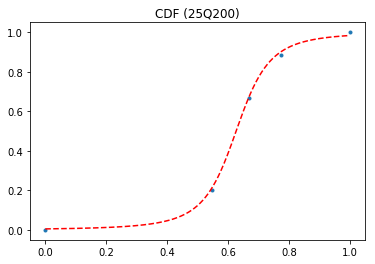

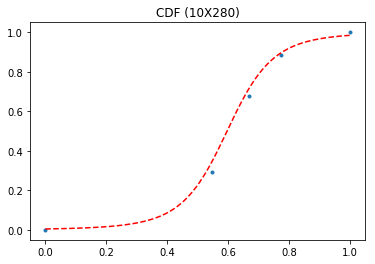

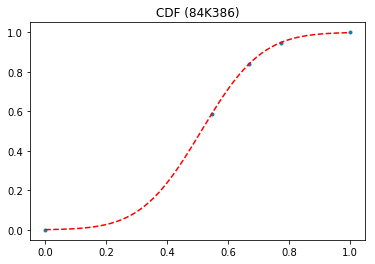

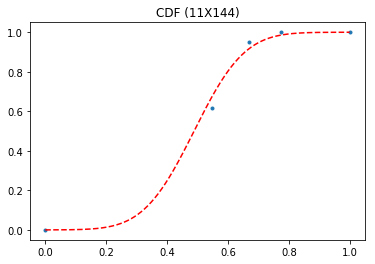

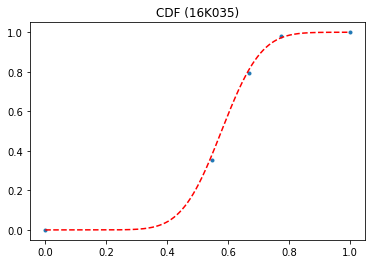

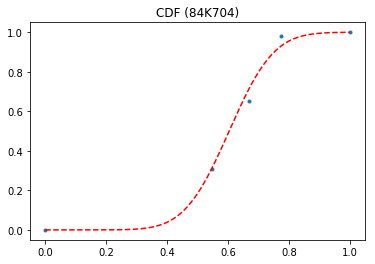

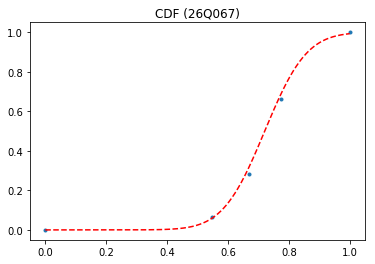

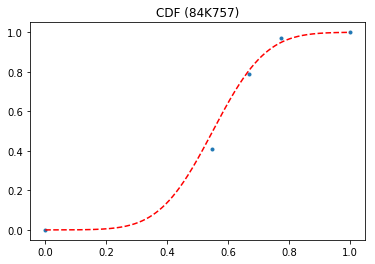

In [9]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import t

# student's T distribution

sample = df.sample(20, random_state=1)
for DBN, row in sample.iterrows():       
    # values
    xs = scaled_ranges[:, 1]
    ys = np.cumsum(row).values
    
    # add initial point
    xs = np.insert(xs, 0, 0)
    ys = np.insert(ys, 0, 0)
    
    # plot
    fig, ax = plt.subplots()
    plt.plot(xs, ys, '.')   
    plt.title('CDF ({})'.format(DBN))
    
    # estimate norm parameters
    mean = scaled_means.loc[DBN]
    def cdf(x, d, scale):
        return t.cdf(x, d, mean, scale)    
    popt, pcov = curve_fit(cdf, xs, ys)
    
    # plot estimated distribution
    xs = np.linspace(0, 1, 1000)
    ys = cdf(xs, *popt)
    plt.plot(xs, ys, 'r--')

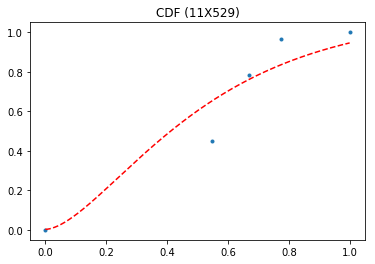

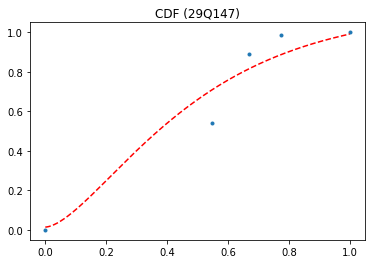

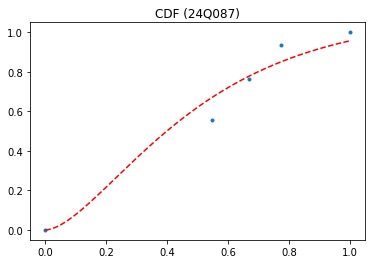

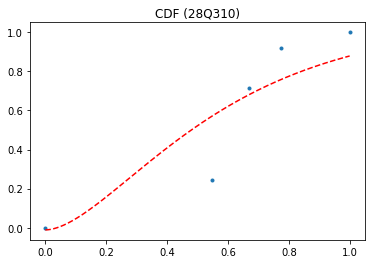

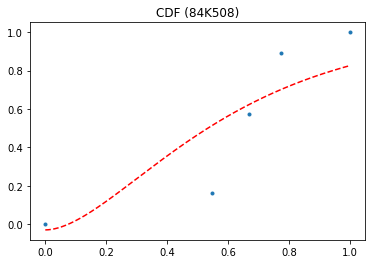

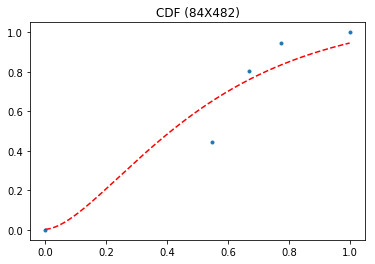

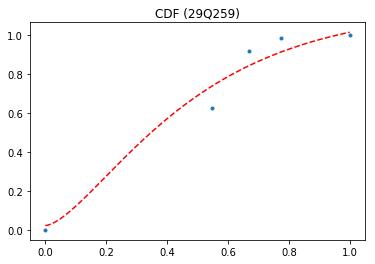

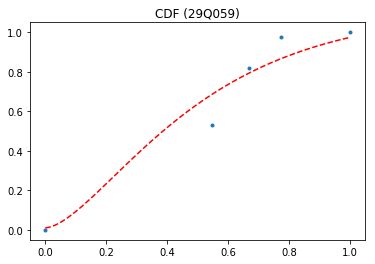

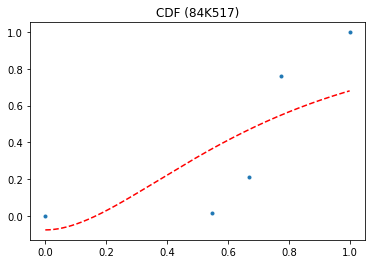

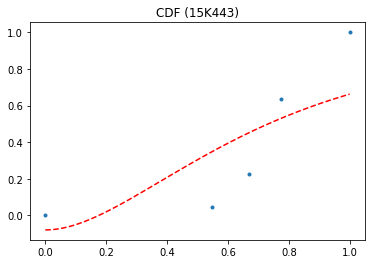

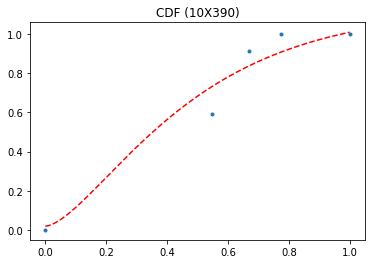

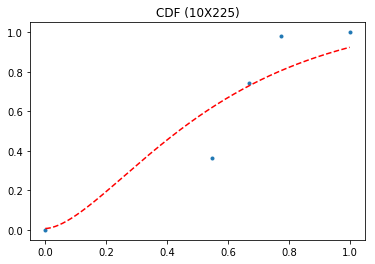

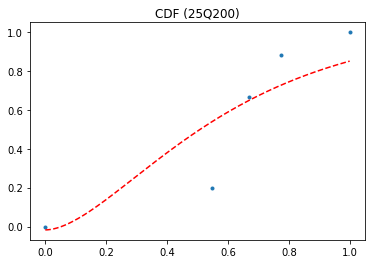

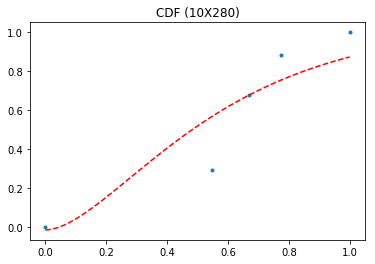

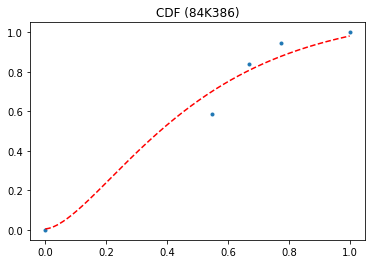

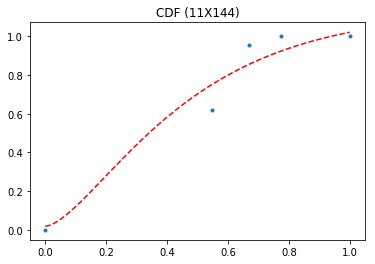

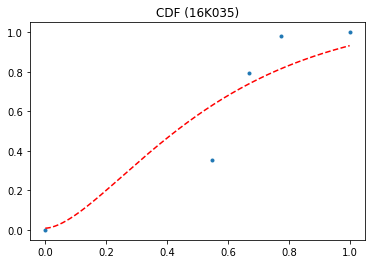

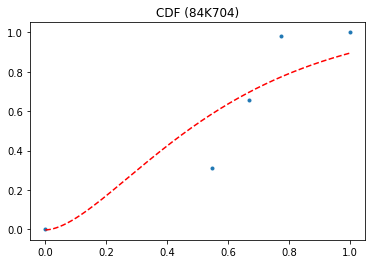

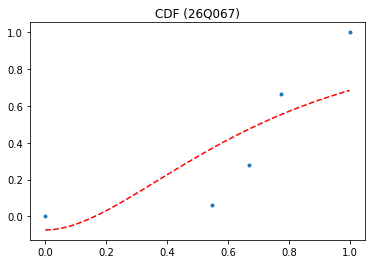

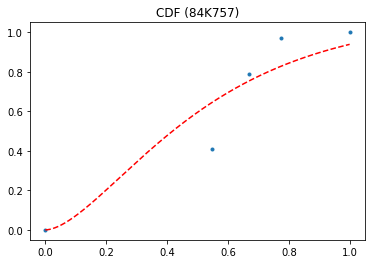

In [51]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import gamma, gammainc
from scipy.stats import norm

# Gamme distribution (not a nice match)

sample = df.sample(20, random_state=1)
for DBN, row in sample.iterrows():       
    # values
    xs = scaled_ranges[:, 1]
    ys = np.cumsum(row).values
    
    # add initial point
    xs = np.insert(xs, 0, 0)
    ys = np.insert(ys, 0, 0)
    
    # plot
    fig, ax = plt.subplots()
    plt.plot(xs, ys, '.')   
    plt.title('CDF ({})'.format(DBN))
    
    # estimate norm parameters
    mean = scaled_means.loc[DBN]
    def cdf(x, a, loc):
        b = a / mean
        return (gammainc(a, b * x) / gamma(a)) + loc
    popt, pcov = curve_fit(cdf, xs, ys)
    
    # plot estimated distribution
    xs = np.linspace(0, 1, 1000)
    ys = cdf(xs, *popt)
    plt.plot(xs, ys, 'r--')

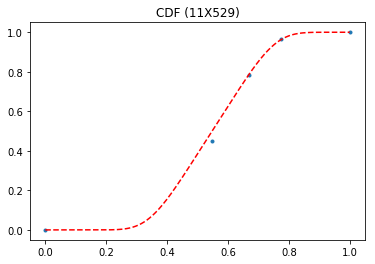

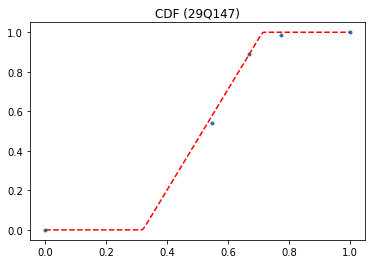

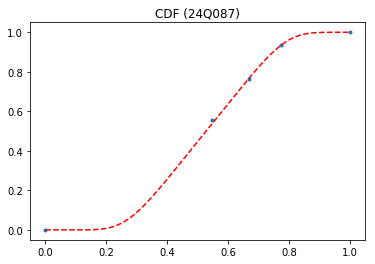

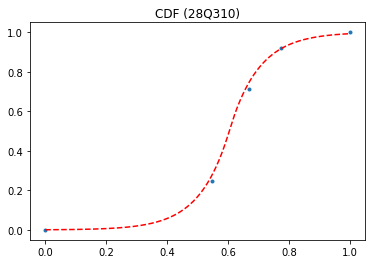

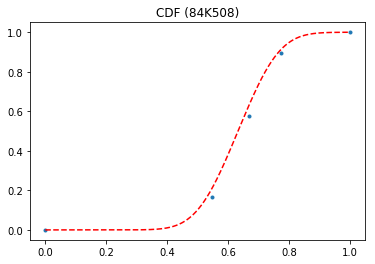

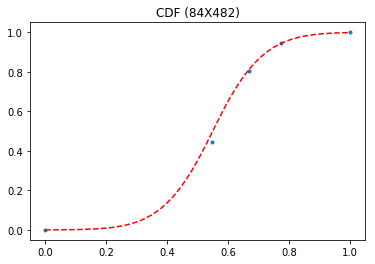

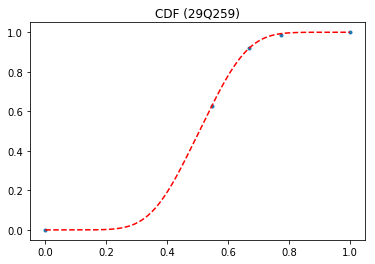

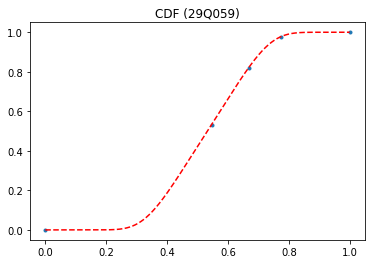

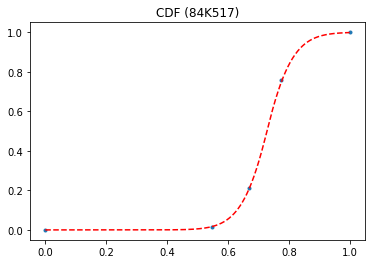

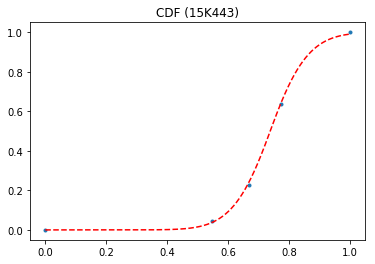

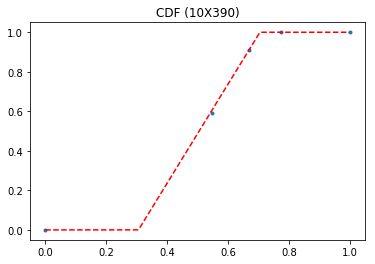

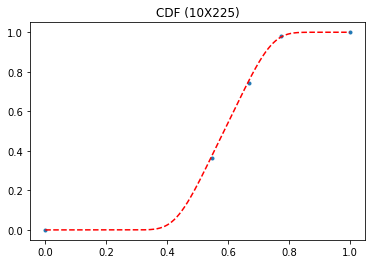

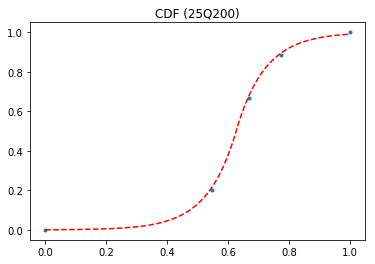

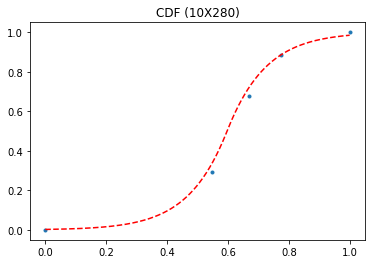

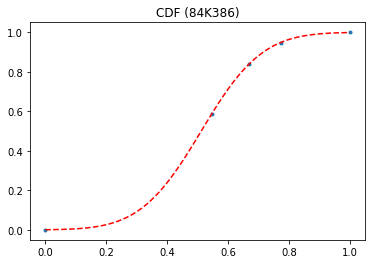

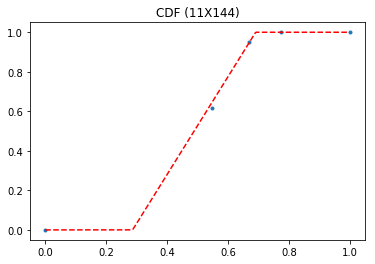

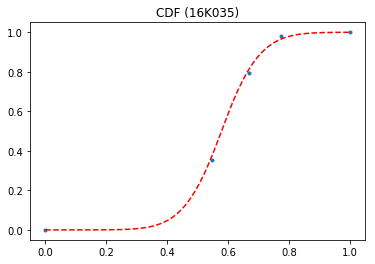

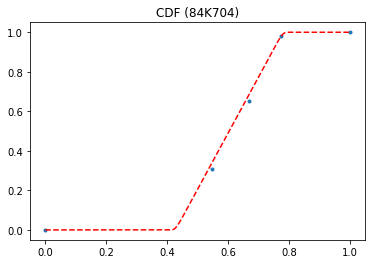

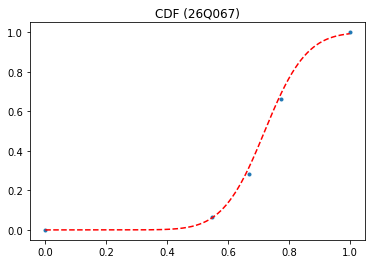

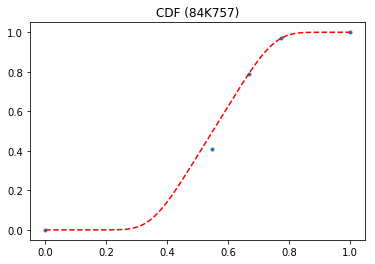

In [52]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import gennorm

# generalized Normal distribution (overfitted)

sample = df.sample(20, random_state=1)
for DBN, row in sample.iterrows():       
    # values
    xs = scaled_ranges[:, 1]
    ys = np.cumsum(row).values
    
    # add initial point
    xs = np.insert(xs, 0, 0)
    ys = np.insert(ys, 0, 0)
    
    # plot
    fig, ax = plt.subplots()
    plt.plot(xs, ys, '.')   
    plt.title('CDF ({})'.format(DBN))
    
    # estimate norm parameters
    mean = scaled_means.loc[DBN]
    def cdf(x, beta, scale):
        return gennorm.cdf(x, beta, mean, scale)    
    popt, pcov = curve_fit(cdf, xs, ys)
    
    # plot estimated distribution
    xs = np.linspace(0, 1, 1000)
    ys = cdf(xs, *popt)
    plt.plot(xs, ys, 'r--')

In [180]:
from scipy.optimize import least_squares
from scipy.stats import truncnorm

def find_optimal_b(a, mean):
    def fn(b_arr):
        b = b_arr[0]
        return truncnorm.mean(a, b, -a, b - a) - mean
        
    opt_result = least_squares(fn, a + 1, bounds=(a, np.inf))
    assert opt_result.success    
    return opt_result.x[0]

find_optimal_b(-1, 0.55)

0.08343969543262554

In [183]:
a = -7
mean = 0.5
b = find_optimal_b(a, mean)

print("A = {}, B = {}".format(a, b))
print("Mean = {}, Expected Mean = {}".format(truncnorm.mean(a, b, -a, b-a), mean))

A = -7, B = -5.933075902627541
Mean = 0.5000000000000968, Expected Mean = 0.5


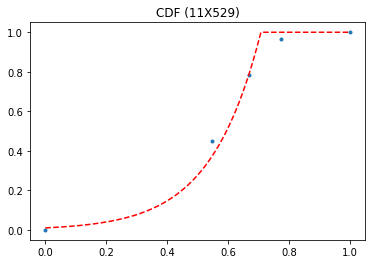

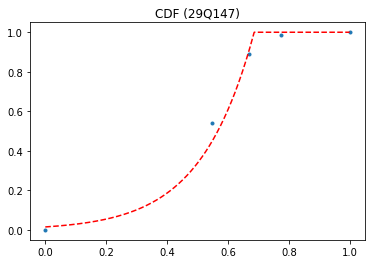

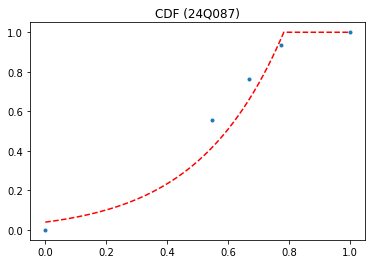

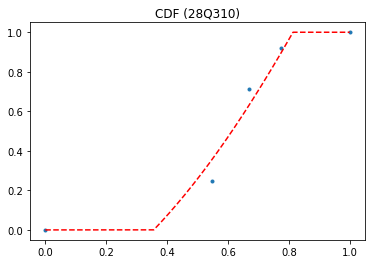

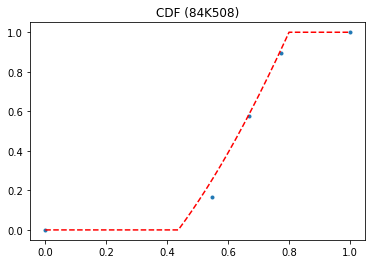

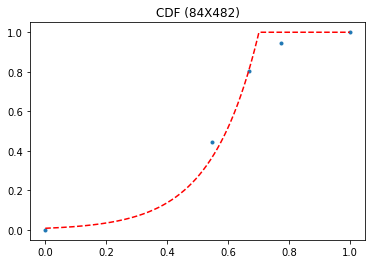

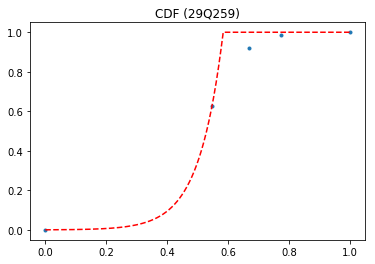

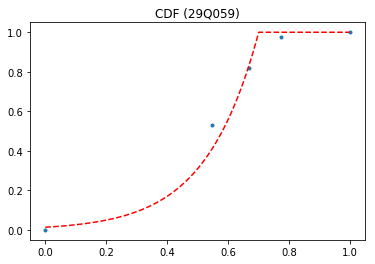

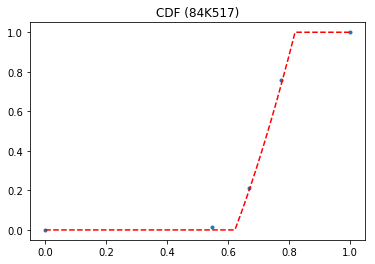

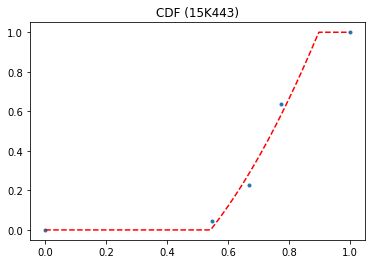

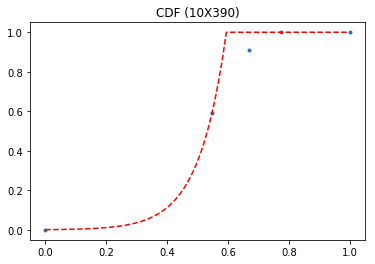

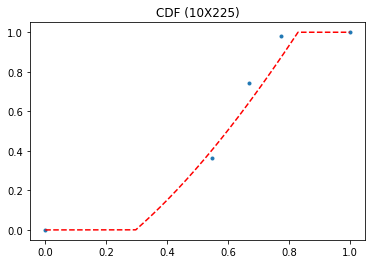

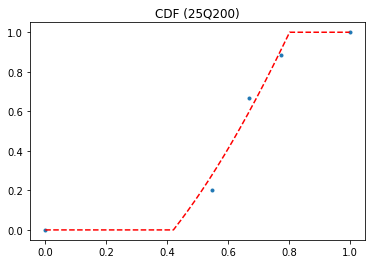

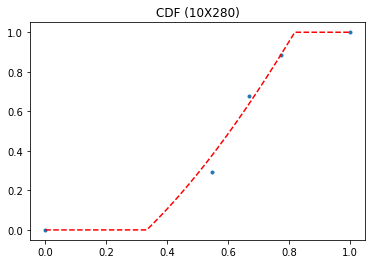

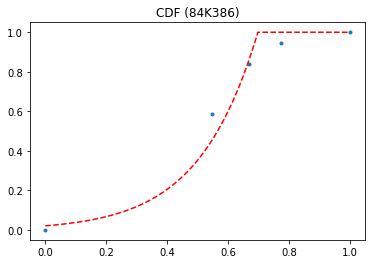

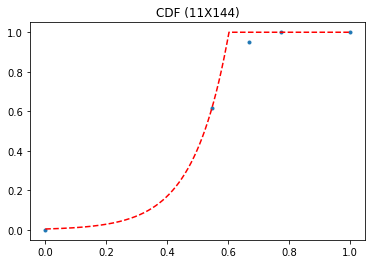

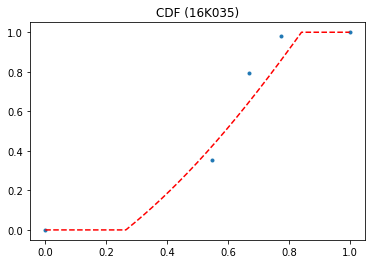

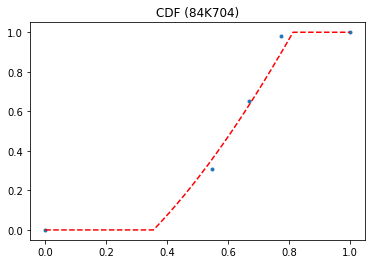

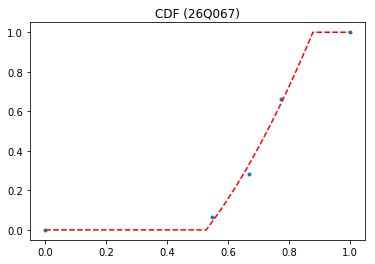

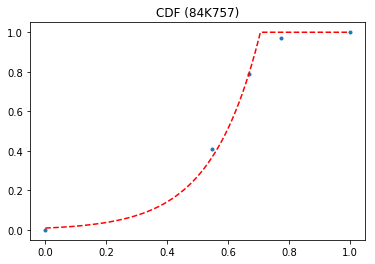

In [195]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import truncnorm

# truncated normal distribution (overfits... too sensible to initial A value)

sample = df.sample(20, random_state=1)
for DBN, row in sample.iterrows():       
    # values
    xs = scaled_ranges[:, 1]
    ys = np.cumsum(row).values
    
    # add initial point
    xs = np.insert(xs, 0, 0)
    ys = np.insert(ys, 0, 0)
    
    # plot
    fig, ax = plt.subplots()
    plt.plot(xs, ys, '.')   
    plt.title('CDF ({})'.format(DBN))
    
    # estimate norm parameters
    mean = scaled_means.loc[DBN]
    def cdf(x, a):
        b = find_optimal_b(a, mean)
        return truncnorm.cdf(x, a, b, -a, b - a)
    popt, pcov = curve_fit(cdf, xs, ys, p0=-2, method='dogbox')
    
    # plot estimated distribution
    xs = np.linspace(0, 1, 1000)
    ys = cdf(xs, *popt)
    plt.plot(xs, ys, 'r--')

# Conclusion

I'm gonna use the beta distribution, since it fit well (almost perfectly, maybe a bit of room for improvement) and has bounds where we need them!